To see where the shifts from Julian to Gregorian calendar occur, we'll have to compute correlations w 20CR. However, due to availability of data and storage space in scratch2, I can't take subdaily comparisons. What I do then is to take always the value in the morning (e.g. 6am) and compare it with the daymean of 20CR. My understanding is that if we are always taking the observation at the same time of the day, it should give the best correlation at the lag days.

In [3]:
import numpy as np
import os
import glob
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

plt.rcParams.update({'font.size':12})

file_savedir = '/home/ccorbella/scratch2_symboliclink/files/station_timeseries_preprocessed/'
file_readdir = '/home/ccorbella/scratch2_symboliclink/files/station_timeseries_orig/Ukraine'

# Define a function to categorize hours into morning, midday, and evening
def tod(hour):
    if hour < 10:
        return "morning"
    elif 10 <= hour < 16:
        return "midday"
    else:
        return "evening"
    
def make_date_col(df):
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors='coerce')
    return df

# Define weights for each hour
default_weights = {"morning": 0.3, "midday": 0.5, "evening": 0.2}
default_weights_ToD = {6:0.3, 14:0.5, 22:0.3}

colors = {"morning": "blue", "midday": "orange", "evening": "green"}
time_categories = ["evening", "midday", "morning"]

# select dates of interest
def select_dates(df):
    df = df[df['Date'] <= '1850-12-31']
    df = df[df['Date'] >= '1806-01-01']
    df.index -= df.index[0] # reset indices
    return df

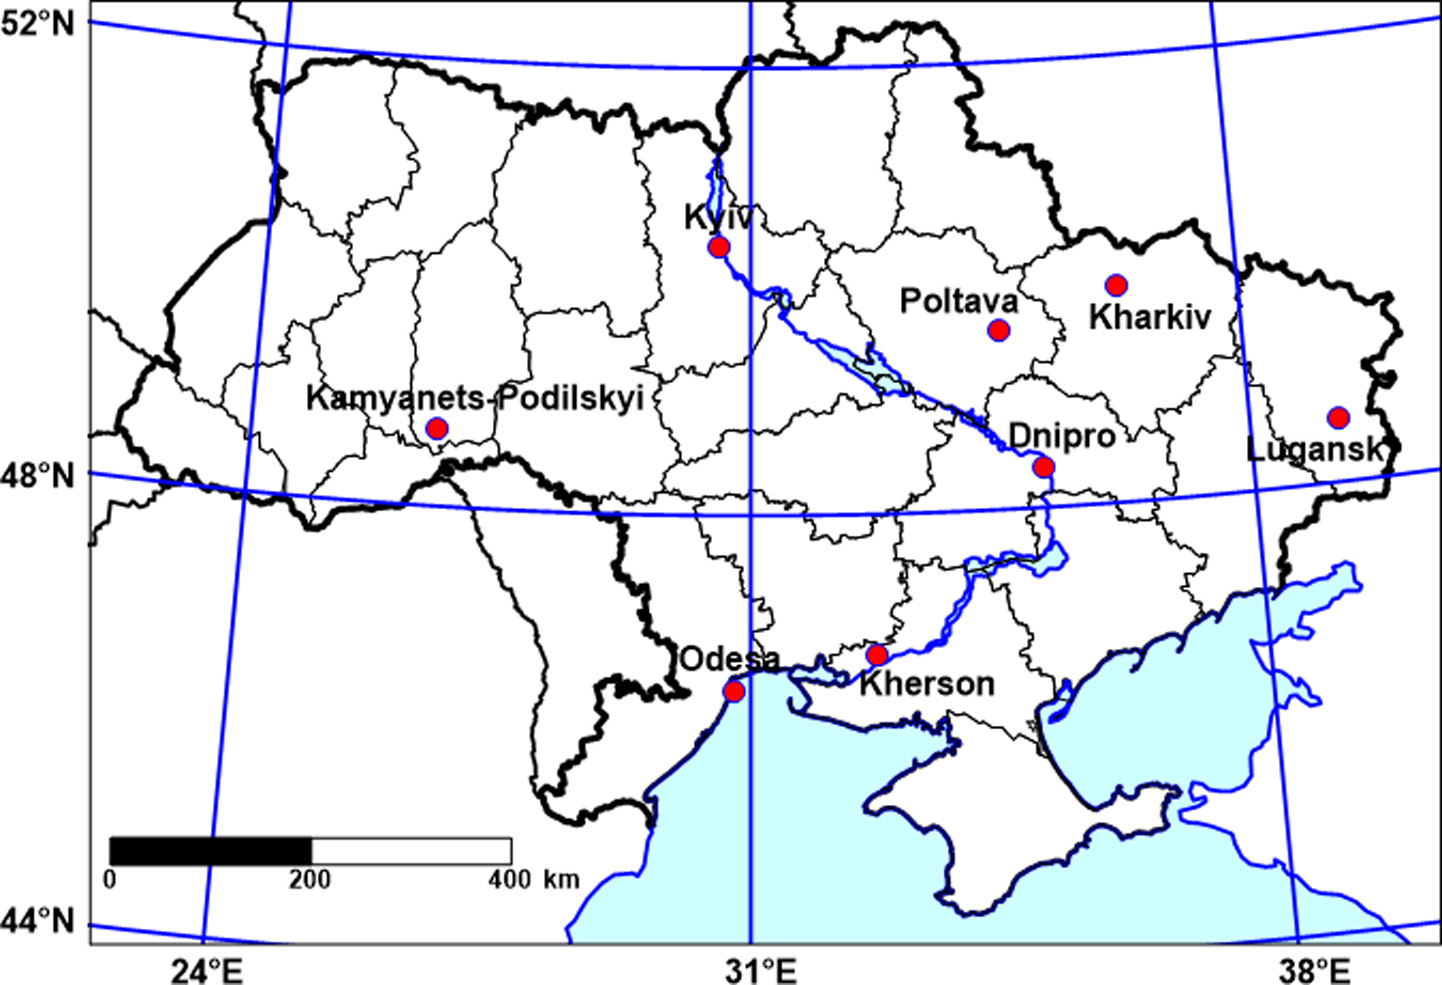

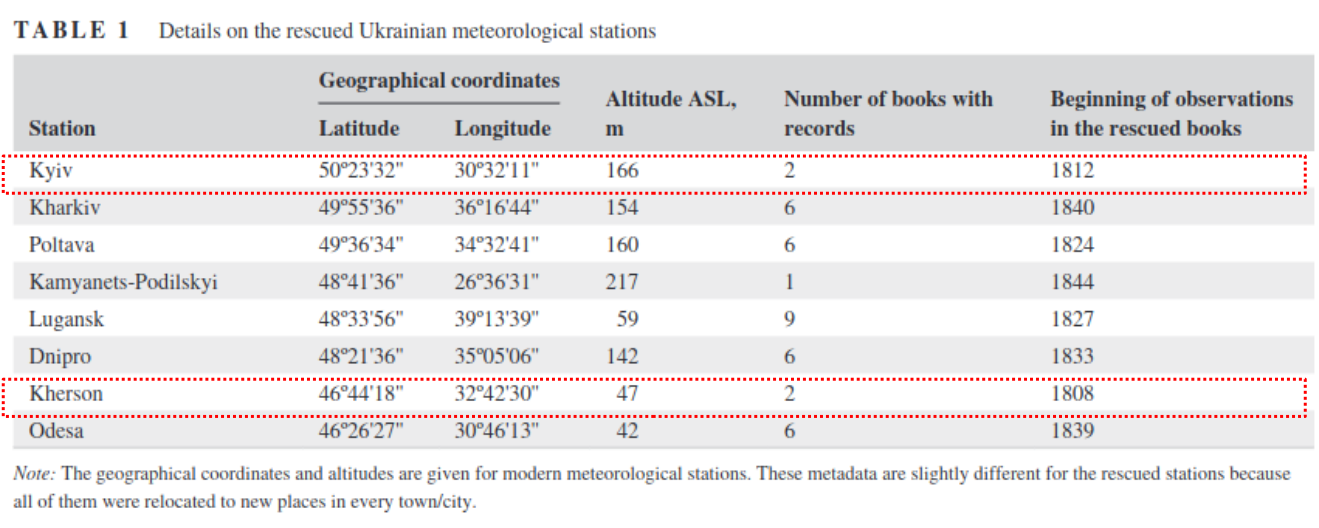

In [11]:
from IPython.display import display, Image
display(Image(filename="image/ukr_map.jpg"))
display(Image(filename="image/ukr_tablestations_rectangle.png"))


## Dnipro

no days with less than 3 obs, yay!


Text(0, 0.5, 'Temperature [°C]')

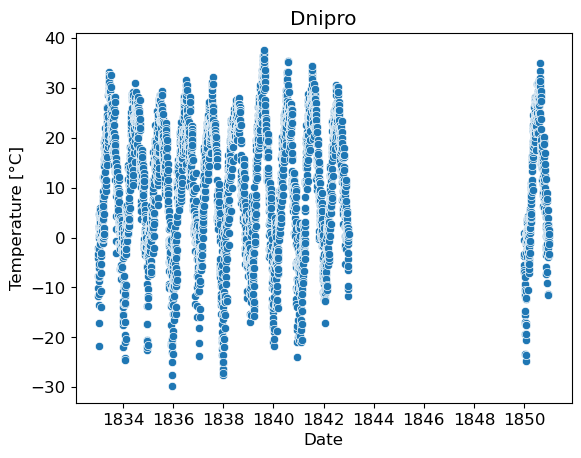

In [2]:
df = pd.read_csv(f'{file_readdir}/Dnipro.tsv', sep='\t',skiprows=12)
make_date_col(df)
df = select_dates(df)
df['P'] = pd.to_numeric(df['P'])
df['T'] = pd.to_numeric(df['T'])
df = df.replace(-999.9,np.NaN)             # replace -999.9 by NaN
df = df.dropna(subset=['T', 'P'], how='all') # drop if both NaN

# check days when less than 3 obs are available
valid_days = df.groupby('Date')['Time'].nunique()
unvalid_dates = valid_days[valid_days!=3].index 
valid_dates   = valid_days[valid_days==3].index # select only dates w 3 obs
df_lt3 = df[df['Date'].isin(unvalid_dates)]

if df_lt3.empty: print('no days with less than 3 obs, yay!')

# weighted average for temperature:
df_ta = df.groupby('Date').apply(
    lambda group: (group['T'] * group['Time'].map(default_weights)).sum()/group['Time'].map(default_weights).sum(),
    include_groups=False
)
df_ta = pd.DataFrame({'TMP2m': df_ta * 1.25}) # conversion to Celsius
df_ta = df_ta.reset_index()
df_ta.to_csv(f'{file_savedir}Ukr-Dnipro_TMP2m.csv')

sns_plot = sns.scatterplot(x=df_ta['Date'].reset_index(drop=True), y=df_ta['TMP2m'])
sns_plot.set_title(r'Dnipro')
sns_plot.set_ylabel('Temperature [°C]')


## Kherson

Check! There are days with less than 3 obs.


Text(0, 0.5, 'Temperature [K]')

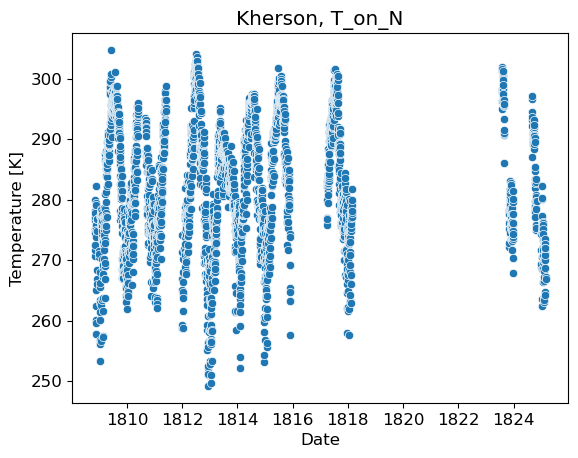

In [17]:
df_TonN = pd.read_csv('/home/ccorbella/scratch2_symboliclink/files/station_timeseries_preprocessed/Ukraine/Kherson_ta_subdaily_TonN.tsv',
                 sep='\t',skiprows=12)
make_date_col(df_TonN)
df_TonN = select_dates(df_TonN)
if np.sum(df_TonN['Value'].isna()) != 0: raise ValueError("there are NAs in SEF file")

# check if there are any days when not all the three obs are available

# check days when less than 3 obs are available
valid_days = df_TonN.groupby('Date')['Hour'].nunique()
invalid_dates = valid_days[valid_days!=3].index 
valid_dates   = valid_days[valid_days==3].index # select only dates w 3 obs
df_lt3 = df_TonN[df_TonN['Date'].isin(invalid_dates)]

if df_lt3.empty: print('no days with less than 3 obs, yay!')
else: print('Check! There are days with less than 3 obs.')

# temporarily drop days wo 3 obs
df_TonN = df_TonN[df_TonN['Date'].isin(valid_dates)]

# weighted average for temperature:
df_TonN_daymean = df_TonN.groupby('Date').apply(
    lambda group: (group['Value'] * group['Hour'].map(default_weights_ToD)).sum() / group['Hour'].map(default_weights_ToD).sum(),
    include_groups=False
).reset_index(name='Daily_Mean')
df_TonN_daymean.to_csv(f'{file_savedir}Ukraine/Kherson_ta_daymean_TonN.csv')

sns_plot = sns.scatterplot(x=df_TonN_daymean['Date'], y=df_TonN_daymean['Daily_Mean'])
sns_plot.set_title('Kherson, T_on_N')
sns_plot.set_ylabel('Temperature [K]')

In [50]:
df_TonS = pd.read_csv('/home/ccorbella/scratch2_symboliclink/files/station_timeseries_preprocessed/Ukraine/Kherson_ta_subdaily_TonS.tsv',
                 sep='\t',skiprows=12)
make_date_col(df_TonS)
df_TonS = select_dates(df_TonS)
if np.sum(df_TonS['Value'].isna()) != 0: raise ValueError("there are NAs in SEF file")

df_p = pd.read_csv('/home/ccorbella/scratch2_symboliclink/files/station_timeseries_preprocessed/Ukraine/Kherson_p_subdaily.tsv',
                 sep='\t',skiprows=12)
make_date_col(df_p)
df_p = select_dates(df_p)
if np.sum(df_p['Value'].isna()) != 0: raise ValueError("there are NAs in SEF file")

# merge ta and p in same df
kherson_all = pd.merge(df_TonS[['Date', 'Value', 'Hour']], df_TonN[['Date','Value', 'Hour']], how="outer", on=["Date","Hour"])
kherson_all = kherson_all.rename(columns={'Value_x':'T_on_S', 'Value_y':'T_on_N'})
kherson_all = kherson_all[['Date', 'Hour', 'T_on_N', 'T_on_S']]

kherson_all = pd.merge(kherson_all, df_p[['Date', 'Hour', 'Value']], how='outer', on=['Date','Hour'])
kherson_all = kherson_all.rename(columns={'Value':'P'})
kherson_all['Time_of_Day'] = kherson_all['Hour'].apply(tod)

kherson_all.head()

,Date,Hour,T_on_N,T_on_S,P,Time_of_Day
0,1808-11-01,6,268.130,277.255,1007.44805,morning
1,1808-11-01,14,278.130,278.505,1007.44805,midday
2,1808-11-01,22,277.255,277.255,995.59572,evening
3,1808-11-02,6,276.005,276.005,1002.36848,morning
4,1808-11-02,14,279.755,283.505,1002.36848,midday


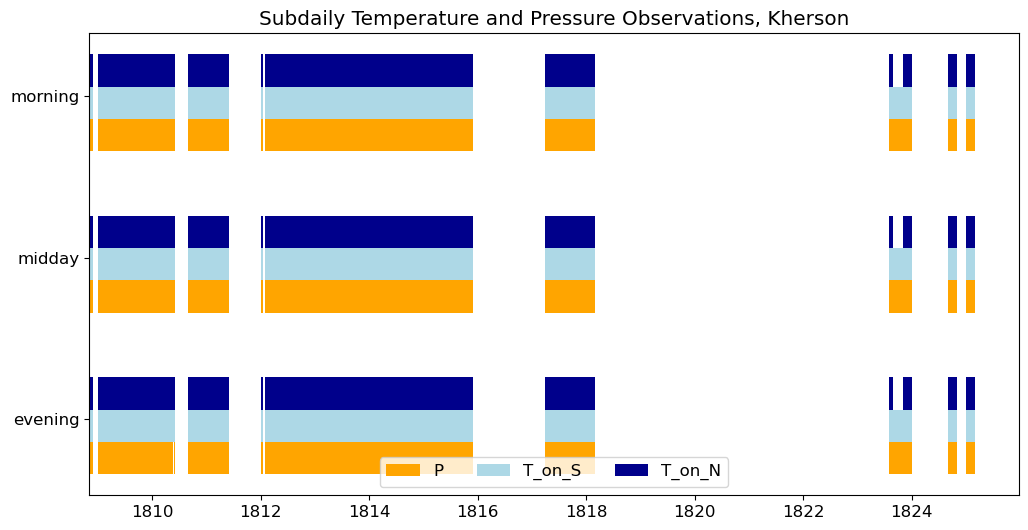

In [52]:
colors = {"T_on_N": "darkblue", "T_on_S": "lightblue", "P": "orange"}

# Create a new figure
fig, ax = plt.subplots(figsize=(12, 6))

# Create positions for each variable within each time category
y_positions = {time: i * 1.5 for i, time in enumerate(time_categories)}
bar_height = 0.9  # Adjusted for better separation

added_labels = set()

# Plot horizontal bars for each variable within each time category
for time_of_day in time_categories:
    for j, var in enumerate(reversed(['T_on_N', 'T_on_S', 'P'])):
        dates = kherson_all[kherson_all[var].notna() & (kherson_all["Time_of_Day"] == time_of_day)]["Date"]
        
        # legend labels, avoid duplicates
        label = var if var not in added_labels else ""
        added_labels.add(var)
        
        ax.barh(
            y=y_positions[time_of_day] + j * (bar_height/3),  # Offset for each variable
            width=1,
            left=dates,
            height=bar_height/3,
            color=colors[var],
            label=label,
        )

# Format the plot
ax.set_yticks([y_positions[time] + bar_height/2.5 for time in time_categories])
ax.set_yticklabels(time_categories)
ax.set_title("Subdaily Temperature and Pressure Observations, Kherson")
ax.legend(loc='lower center', ncol=3)
plt.savefig('/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/dataprep/image/Kherson_obscounts_tod.png')
plt.show()

it can be misleading, because I'm removing the days where ALL the `T_on_N`, `T_on_S` and `P` are missing. There are days, however, where only one of these 3 vars is missing, or 2 of them. if one of the `T` vars is  missing, doing the average with `df['T'] = (df['T_on_N']+df['T_on_S'])/2` is wrong. I now want to explore some way that can tell me the days in which one of these obs is missing.

In [53]:
# Identify days where at least one of the three variables is missing

# Create a boolean mask for missing observations
missing_obs = kherson_all[['T_on_N', 'T_on_S', 'P']].isna()

# Count the number of missing values per day
missing_obs_per_day = kherson_all.groupby('Date')[['T_on_N', 'T_on_S', 'P']].apply(lambda x: x.isna().sum())

# Filter to show only dates where at least one variable is missing (but not all)
incomplete_days = missing_obs_per_day[(missing_obs_per_day > 0).any(axis=1)]
incomplete_days.to_csv(f'{file_readdir}/Kherson_incomplete_days.csv')
incomplete_days.sum()

T_on_N    195
T_on_S      3
P           1
dtype: int64

## Kyív

Check! There are days with less than 3 obs.


/tmp/ipykernel_2579217/1868146768.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ta = df.groupby('Date').apply(


Text(0, 0.5, 'Temperature [°C]')

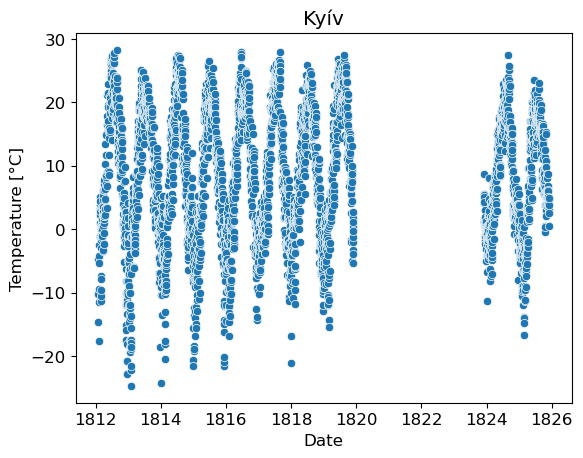

In [57]:
df = pd.read_csv(f'{file_readdir}/Kyiv_ta_pre1837.tsv', sep='\t',skiprows=12)
make_date_col(df)
df = select_dates(df)
df['Value'] = pd.to_numeric(df['Value'])
df = df.replace(-999.9,np.NaN)          # replace -999.9 by NaN
df = df.dropna(subset=['Value'], how='all') # drop if both NaN

# check days when less than 3 obs are available
valid_days = df.groupby('Date')['Time'].nunique()
invalid_dates = valid_days[valid_days!=3].index 
valid_dates   = valid_days[valid_days==3].index # select only dates w 3 obs
df_lt3 = df[df['Date'].isin(invalid_dates)]

if df_lt3.empty: print('no days with less than 3 obs, yay!')
else: print('Check! There are days with less than 3 obs.')

df = df[df['Date'].isin(valid_dates)]

# weighted average for temperature:
df_ta = df.groupby('Date').apply(
    lambda group: (group['Value'] * group['Time'].map(default_weights)).sum()/group['Time'].map(default_weights).sum()
)
df_ta = pd.DataFrame({'TMP2m': df_ta * 1.25})
df_ta = df_ta.reset_index()
df_ta.to_csv(f'{file_savedir}Ukr_Kyiv.csv')

sns_plot = sns.scatterplot(x=df_ta['Date'].reset_index(drop=True), y=df_ta['TMP2m'])
sns_plot.set_title(r'Kyív')
sns_plot.set_ylabel('Temperature [°C]')


look at times of day when observations are missing

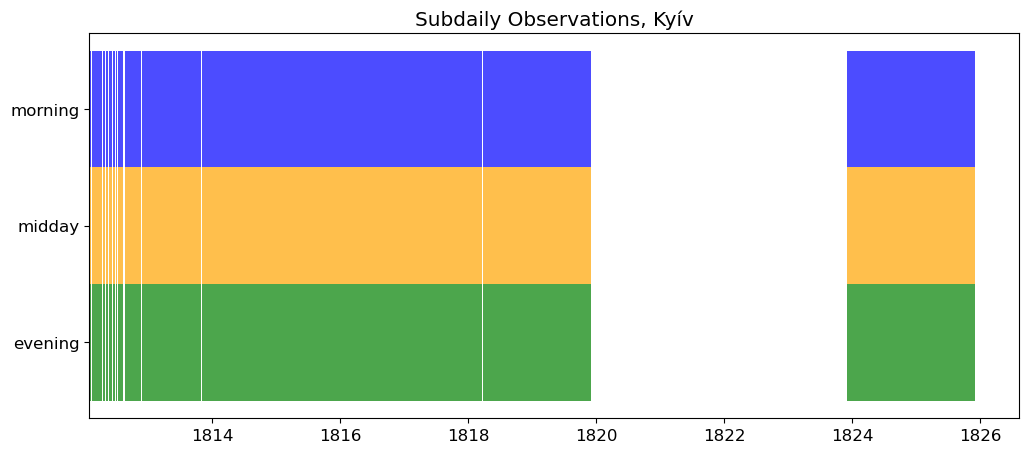

In [58]:
df_short = df#[df['Date']<'1820-01-01']
missing_counts={}
colors = {"morning": "blue", "midday": "orange", "evening": "green"}

# Create the plot with dates on the x-axis and time categories on the y-axis
fig, ax = plt.subplots(figsize=(12, 5))

# Define y-axis positions for the time categories
y_positions = {time: i for i, time in enumerate(time_categories)}

# Plot horizontal bars for each time of day
for time_of_day in time_categories:
    dates = df_short[df_short["Time"] == time_of_day]["Date"]
    ax.barh(y=y_positions[time_of_day], width=1, left=dates,
            height=1, color=colors[time_of_day], label=time_of_day, alpha=0.7)

    total_dates = df_short['Date'].nunique()
    present_dates = dates.nunique()
    missing_counts[time_of_day] = total_dates - present_dates

ax.set_yticks(range(len(time_categories)))
ax.set_yticklabels(time_categories)
ax.set_title("Subdaily Observations, Kyív")

plt.savefig('/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/dataprep/image/Kyiv_obscounts_tod.png')
plt.show()


## Calendar Shift identification
analyze potential misalignments in the seasonal cycle by computing rolling averages, month-to-month correlations, and test for potential Julian-Gregorian shifts

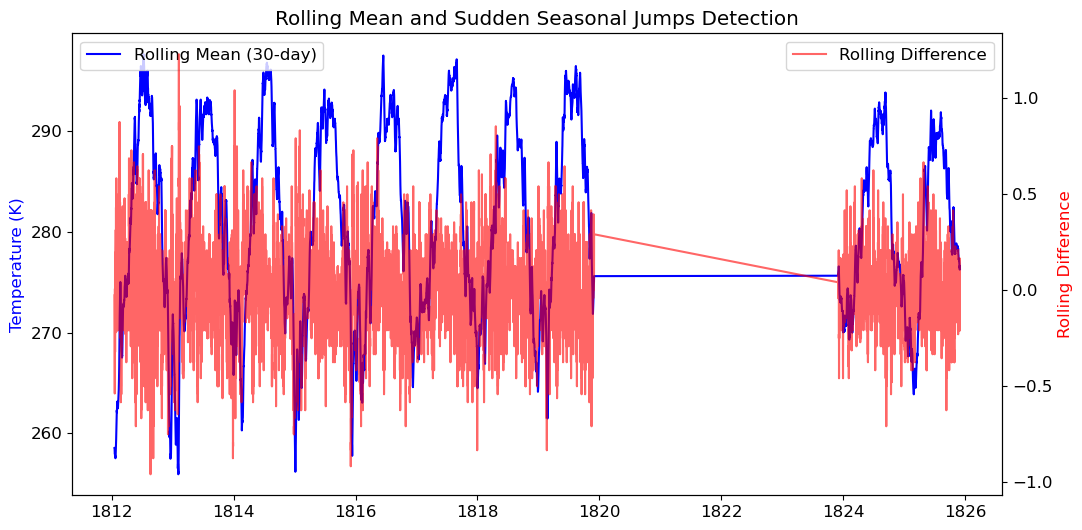

In [59]:
# Read the file again, skipping the metadata header (lines before "Year\tMonth\tDay...")
df = pd.read_csv('/home/ccorbella/scratch2_symboliclink/files/station_timeseries_preprocessed/Ukraine/Kyiv_ta_subdaily.tsv', sep="\t", skiprows=12)

# Rename columns for clarity
df.columns = ["Year", "Month", "Day", "Hour", "Minute", "Period", "Value", "Meta"]

# Convert date columns to a proper datetime format
df["Datetime"] = pd.to_datetime(df[["Year", "Month", "Day", "Hour", "Minute"]])

# Drop unnecessary columns for now
df = df[["Datetime", "Value"]]

# Sort by date in case the data isn't ordered
df = df.sort_values("Datetime").reset_index(drop=True)

# Compute day-of-year for each observation
df["Day_of_Year"] = df["Datetime"].dt.dayofyear

# Compute rolling mean (e.g., 30-day window) to smooth seasonal cycle
df["Rolling_Mean"] = df["Value"].rolling(window=30, min_periods=10, center=True).mean()

# Identify potential jumps by checking sudden shifts in rolling mean differences
df["Rolling_Diff"] = df["Rolling_Mean"].diff()

# Plot the rolling mean and differences to visualize any sudden jumps
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df["Datetime"], df["Rolling_Mean"], label="Rolling Mean (30-day)", color="blue")
ax1.set_ylabel("Temperature (K)", color="blue")
ax1.set_title("Rolling Mean and Sudden Seasonal Jumps Detection")

ax2 = ax1.twinx()
ax2.plot(df["Datetime"], df["Rolling_Diff"], label="Rolling Difference", color="red", alpha=0.6)
ax2.set_ylabel("Rolling Difference", color="red")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()


- analyze specific time periods where jumps occur.
- apply a Julian-Gregorian offset and see if alignment improves.



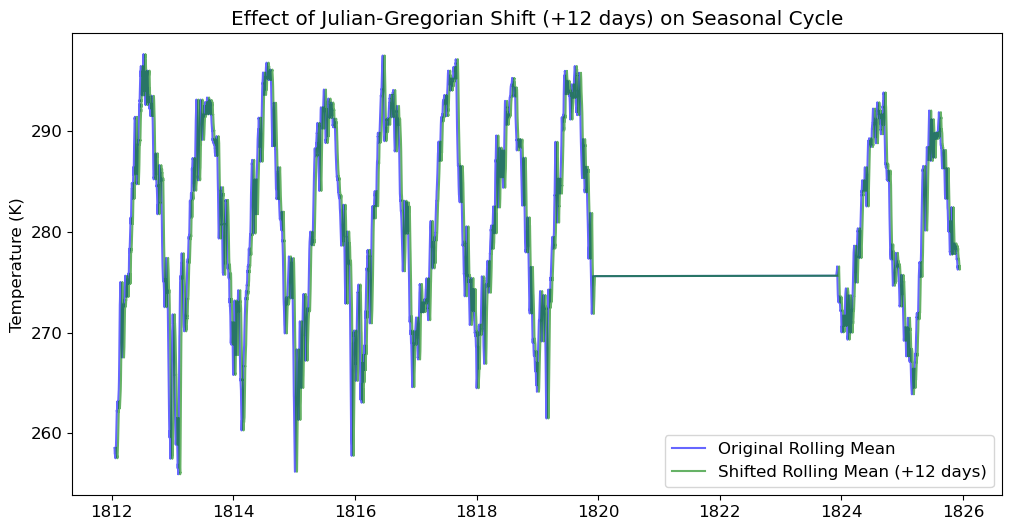

In [60]:
# Identify significant jumps by finding where rolling difference exceeds a threshold
threshold = df["Rolling_Diff"].std() * 3  # Using 3 standard deviations as a threshold for anomalies
jump_indices = df[np.abs(df["Rolling_Diff"]) > threshold].index

# Extract periods around the detected jumps
jump_periods = df.loc[jump_indices, ["Datetime", "Rolling_Diff"]]

# Display the identified jump periods

# Apply a Julian-Gregorian shift (+12 days) to check if alignment improves
df["Shifted_Datetime"] = df["Datetime"] + pd.DateOffset(days=12)

# Compute a new rolling mean for the shifted time series
df["Shifted_Rolling_Mean"] = df["Value"].rolling(window=30, min_periods=10, center=True).mean()

# Plot original vs. shifted time series for comparison
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["Datetime"], df["Rolling_Mean"], label="Original Rolling Mean", color="blue", alpha=0.6)
ax.plot(df["Shifted_Datetime"], df["Shifted_Rolling_Mean"], label="Shifted Rolling Mean (+12 days)", color="green", alpha=0.6)

ax.set_ylabel("Temperature (K)")
ax.set_title("Effect of Julian-Gregorian Shift (+12 days) on Seasonal Cycle")
ax.legend()
plt.show()


We didn't find any obvious calendar shift. Now we'll compute Pearson correlation between the adjusted historical observations and 20CRv3 for various lagged offsets (e.g., ±14 days) to detect potential systematic shifts. We have a csv file with the daymean of different dates and a specific location and a 20CRv3 dataset.

|          | Kyív         | Kherson                      |
| :----------- | :--------------: | -------------------------: |
| Lat | 50.39222 | 46.73833  |
| Lon | 30.53639   | 32.70833 |

Load station data. Comment/ uncomment coordinates accordingly!!

In [61]:
lat_Kherson, lon_Kherson = 46.73833, 32.70833 # for Kherson
lat_Kyiv, lon_Kyiv = 50.39222, 30.53639 # for Kyív

df = pd.read_csv(f'{file_savedir}/Kyiv_ta.tsv', # type 'Kherson' or 'Kyiv accordingly
                 skiprows=12, sep='\t')
make_date_col(df)
df_short = df[['Date','Value']]
df_short['Date'] = pd.to_datetime(df_short['Date']).dt.date

# make sure there are no repeated dates
assert df_short['Date'].nunique() == df_short.shape[0], "repeated dates"

/tmp/ipykernel_2579217/3371663548.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_short['Date'] = pd.to_datetime(df_short['Date']).dt.date


Load 20CR data. Chage `lat` and `lon` accordingly!!

In [62]:
import xarray as xr
from scipy.spatial import KDTree # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html#scipy.spatial.KDTree

# open downloaded dataset from 20CRv3
ds_20CR = xr.open_dataset('/scratch2/ccorbella/files/20CRv3_ensembles/TMP2m.Europe.allmems/TMP2m.Europe.allmems.allyears.nc')
ds_lats = ds_20CR['lat'].values
ds_lons = ds_20CR['lon'].values

# Extract grid points from 20CR dataset
grid_lons, grid_lats = np.meshgrid(ds_lons, ds_lats)

# Flatten the grid
grid_points = np.array([grid_lats.flatten(), grid_lons.flatten()]).T

def create_df_merged(lat_station, lon_station, ds_20CR, station_name):
    
    df = pd.read_csv(f'{file_savedir}/{station_name}_ta.tsv', # type 'Kherson' or 'Kyiv accordingly
                    skiprows=12, sep='\t')
    make_date_col(df)
    df_short = df[['Date','Value']]
    df_short['Date'] = pd.to_datetime(df_short['Date']).dt.date

    # make sure there are no repeated dates
    assert df_short['Date'].nunique() == df_short.shape[0], "repeated dates"

    # Build a KDTree for quick nearest-neighbor lookup
    tree = KDTree(grid_points)

    distances, station_index = tree.query(np.array([lat_station, lon_station]).T)

    # Convert the flattened index back to (lat, lon) indices
    lat_index = station_index // len(ds_lons)
    lon_index = station_index % len(ds_lons)

    print(ds_lats[lat_index], ds_lons[lon_index])

    ds_ta = ds_20CR['TMP2m'][:,:,lat_index,lon_index]
    ds_ta = ds_ta.mean(dim='ensemble_member')

    df_20CR = ds_ta.to_dataframe().reset_index()

    df_20CR = df_20CR.rename(columns={'time':'Date', 'TMP2m':'Value'})
    df_20CR = df_20CR.drop(columns={'lat','lon'})
    df_20CR["Date"] = pd.to_datetime(df_20CR["Date"]).dt.date
    df_merged = pd.merge(df_20CR, df_short, on='Date',how='inner')
    df_merged = df_merged.rename(columns={'Value_x':'model', 'Value_y':'obs'})
    df_merged.head()

    return(df_merged)

def compute_lag_corr(df, max_lag=14):
    """
    Computes Pearson correlation for various time lags.
    """
    
    lags = np.arange(-max_lag, max_lag + 1)
    corrs = []

    for lag in lags:
        shifted_df = df.copy()
        shifted_df["lagged_model"] = shifted_df["model"].shift(lag)
        
        # Drop NaNs introduced by shifting
        shifted_df = shifted_df.dropna(subset=["obs", "lagged_model"])
        
        # Compute Pearson correlation
        if len(shifted_df) > 10:  # Ensure enough data points
            corr, _ = pearsonr(shifted_df["obs"], shifted_df["lagged_model"])
        else:
            corr = np.nan
        
        corrs.append(corr)

    return lags, corrs


**Compute Pearson Correlation for Different Lags**

/tmp/ipykernel_2579217/986841608.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_short['Date'] = pd.to_datetime(df_short['Date']).dt.date


50.175308058833394 30.234375


/tmp/ipykernel_2579217/986841608.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_short['Date'] = pd.to_datetime(df_short['Date']).dt.date


46.666551287054936 33.046875


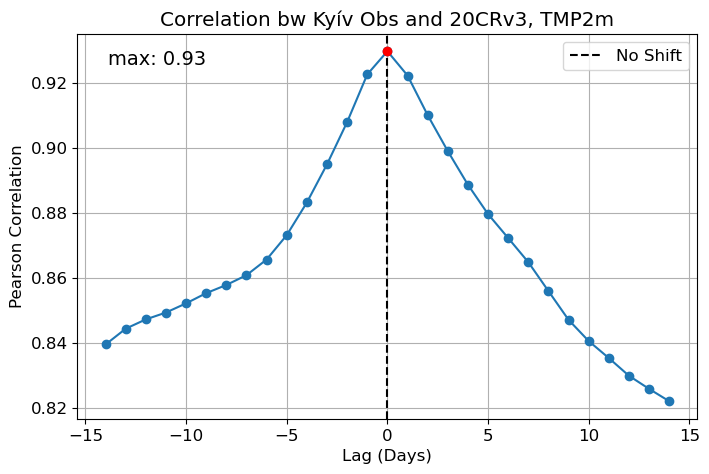

In [63]:
lat_Kherson, lon_Kherson = 46.73833, 32.70833 # for Kherson
lat_Kyiv, lon_Kyiv = 50.39222, 30.53639 # for Kyív

df_merged_Kyiv = create_df_merged(lat_station=lat_Kyiv, lon_station=lon_Kyiv,
                             ds_20CR=ds_20CR,
                             station_name='Kyiv')

df_merged_Kherson = create_df_merged(lat_station=lat_Kherson, lon_station=lon_Kherson,
                             ds_20CR=ds_20CR,
                             station_name='Kherson')
                             
# Compute correlation for lags from -14 to +14 days for Kyív
lags, corrs = compute_lag_corr(df_merged_Kyiv)

# Plot correlation vs. lag
plt.figure(figsize=(8, 5))
ax = plt.gca()
plt.plot(lags, corrs, marker="o", linestyle="-")
plt.axvline(0, color="black", linestyle="--", label="No Shift")
plt.xlabel("Lag (Days)")
plt.plot(lags[np.where(corrs==np.max(corrs))][0], np.max(corrs), marker="o",color="red")
plt.ylabel("Pearson Correlation")
plt.text(0.05, 0.92, f'max: {np.max(corrs):.2f}',
         transform=ax.transAxes, fontsize=14)
plt.title("Correlation bw Kyív Obs and 20CRv3, TMP2m")
plt.legend()
plt.grid()
plt.show()


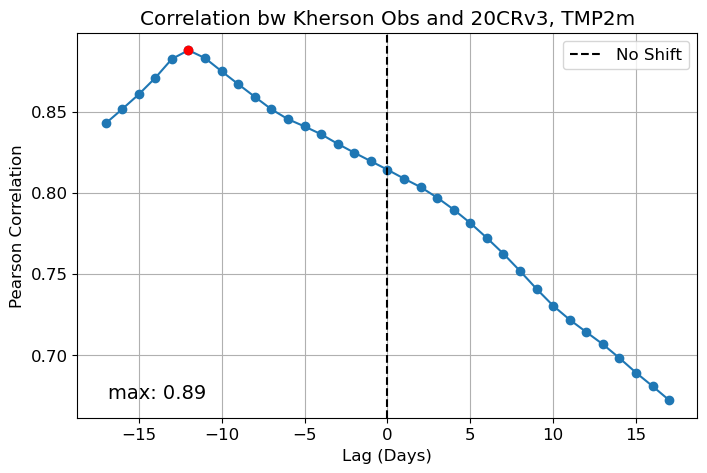

In [64]:
# Compute correlation for lags from -14 to +14 days for Kherson
lags, corrs = compute_lag_corr(df_merged_Kherson, max_lag=17)

# Plot correlation vs. lag
plt.figure(figsize=(8, 5))
ax = plt.gca()
plt.plot(lags, corrs, marker="o", linestyle="-")
plt.plot(lags[np.where(corrs==np.max(corrs))][0], np.max(corrs), marker="o",color="red")
plt.axvline(0, color="black", linestyle="--", label="No Shift")
plt.xlabel("Lag (Days)")
plt.ylabel("Pearson Correlation")
plt.text(0.05, 0.05, f'max: {np.max(corrs):.2f}',
         transform=ax.transAxes, fontsize=14)
plt.title("Correlation bw Kherson Obs and 20CRv3, TMP2m")
plt.legend()
plt.grid()
plt.show()

In [68]:
def rolling_lag_corr(df, window_size=365*3, step_size=90, max_lag=14):
    """
    Computes Pearson correlation for rolling time windows at different lags.
    
    Args:
        df (DataFrame): Contains 'Datetime', 'obs' (station), 'model' (20CR).
        window_size (int): Rolling window size in days.
        step_size (int): How far the window moves in days (default 3 months).
        max_lag (int): Maximum lag to test (both positive and negative).

    Returns:
        DataFrame: Best lag and correlation over time.
    """
    lags = np.arange(-max_lag, max_lag + 1)
    results = []

    for start in range(0, len(df) - window_size, step_size):  # Move window every 3 months
        sub_df = df.iloc[start:start + window_size]
        date_center = sub_df.iloc[window_size // 2]["Date"]  # Approximate center of window
        best_corr = -np.inf
        best_lag = 0
        
        for lag in lags:
            shifted_df = sub_df.copy()
            shifted_df["Lagged_model"] = shifted_df["model"].shift(lag)
            valid_data = shifted_df.dropna(subset=["obs", "Lagged_model"])
            
            if len(valid_data) > 10:  # Ensure enough data points
                corr, _ = pearsonr(valid_data["obs"], valid_data["Lagged_model"])
                if corr > best_corr:
                    best_corr = corr
                    best_lag = lag
        
        results.append({"Date": date_center, "Best_Lag": best_lag, "Best_Corr": best_corr})

    return pd.DataFrame(results)

# Compute rolling lagged correlation (e.g., using a 3-year window)
rolling_Kherson = rolling_lag_corr(df_merged_Kherson)
rolling_Kyiv    = rolling_lag_corr(df_merged_Kyiv)

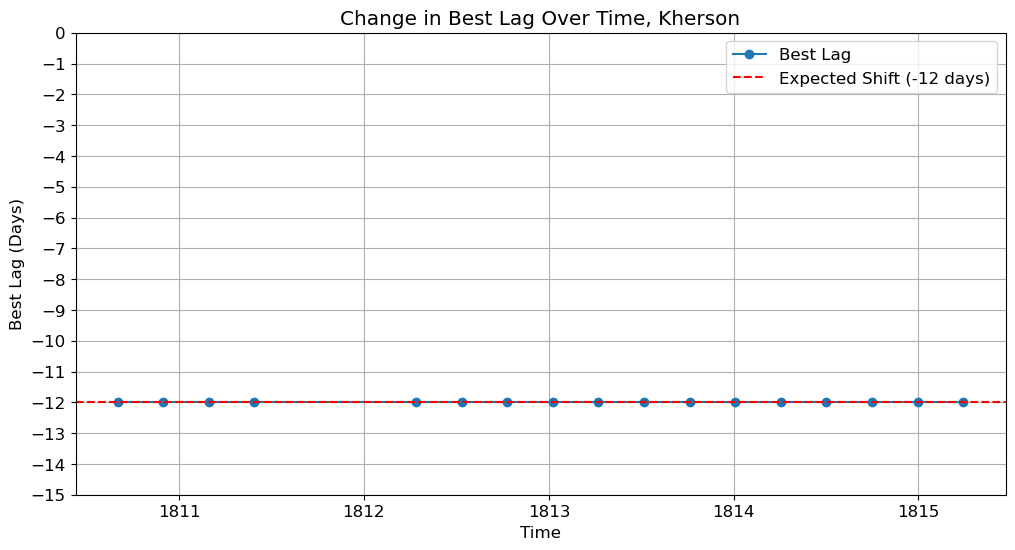

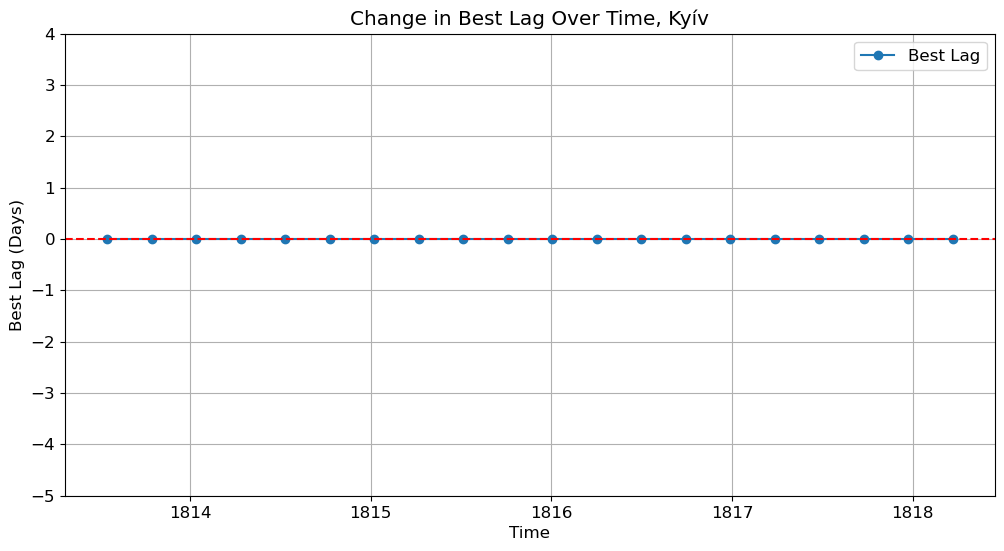

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(rolling_Kherson["Date"], rolling_Kherson["Best_Lag"], marker="o", linestyle="-", label="Best Lag")
plt.axhline(-12, color="r", linestyle="--", label="Expected Shift (-12 days)")
plt.xlabel("Time")
plt.ylabel("Best Lag (Days)")
plt.title("Change in Best Lag Over Time, Kherson")
plt.yticks(range(-15,1))
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(rolling_Kyiv["Date"], rolling_Kyiv["Best_Lag"], marker="o", linestyle="-", label="Best Lag")
plt.axhline(0, color="r", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Best Lag (Days)")
plt.yticks(range(-5,5))
plt.title("Change in Best Lag Over Time, Kyív")
plt.legend()
plt.grid()
plt.show()
